# Load in Cleaned Dataset: `demo_killings_df`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from collections import defaultdict
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import RandomOverSampler

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss, precision_score, recall_score, precision_recall_curve, f1_score, fbeta_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import fbeta_score, make_scorer

In [2]:
with open('Data/demo_killings_df.pkl','rb') as read_file:
    demo_killings_df = pickle.load(read_file)

In [3]:
demo_killings_df

,merge_key,id,name,date,year,month,day_of_week,manner_of_death,armed,age,...,flee,body_camera,poverty_rate,percent_completed_hs,share_white,share_black,share_native_american,share_asian,share_hispanic,median_income
0,Shelton_WA,3,Tim Elliot,2015-01-02,2015,January,Friday,shot,gun,53.0,...,Not fleeing,False,28.6,80.1,78.9,0.8,3.7,1.1,19.2,37072.0
1,Aloha_OR,4,Lewis Lee Lembke,2015-01-02,2015,January,Friday,shot,gun,47.0,...,Not fleeing,False,14.9,88.1,70.9,2.6,1.0,8.9,21.1,65765.0
2,Wichita_KS,5,John Paul Quintero,2015-01-03,2015,January,Saturday,shot and Tasered,unarmed,23.0,...,Not fleeing,False,17.3,87.5,71.9,11.5,1.2,4.8,15.3,45947.0
3,San_Francisco_CA,8,Matthew Hoffman,2015-01-04,2015,January,Sunday,shot,toy weapon,32.0,...,Not fleeing,False,13.2,87.0,48.5,6.1,0.5,33.3,15.1,81294.0
4,Evans_CO,9,Michael Rodriguez,2015-01-04,2015,January,Sunday,shot,nail gun,39.0,...,Not fleeing,False,16.6,76.3,76.5,0.9,1.2,0.9,43.1,47791.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2345,Chowchilla_CA,2812,Alejandro Alvarado,2017-07-27,2017,July,Thursday,shot,knife,33.0,...,Not fleeing,False,32.1,68.3,61.6,12.6,2.0,2.1,37.8,34559.0
2346,Kansas_City_MO,2822,Rodney E. Jacobs,2017-07-28,2017,July,Friday,shot,gun,31.0,...,Not fleeing,False,19.0,88.4,59.2,29.9,0.5,2.5,10.0,45821.0
2347,Albuquerque_NM,2813,TK TK,2017-07-28,2017,July,Friday,shot,vehicle,34.0,...,Car,False,19.2,89.0,69.7,3.3,4.6,2.6,46.7,47030.0
2348,Melba_ID,2818,Dennis W. Robinson,2017-07-29,2017,July,Saturday,shot,gun,48.0,...,Car,False,16.4,90.4,78.9,0.2,0.0,0.2,24.6,41154.0


# Prepare Dataset for Modeling

## Consolidate to specific races (W, B, H)

In [4]:
class_killings_df = demo_killings_df.loc[demo_killings_df['race'].isin(['W', 'B', 'H'])].reset_index(drop=True)


In [5]:
class_killings_df.race.value_counts()

W    1066
B     587
H     421
Name: race, dtype: int64

## Convert Features to Desired Data Types

- numerical
    - year
    - age
    - poverty_rate
    - percent_completed_hs
    - share_white
    - share_black
    - share_native_american
    - share_asian
    - share_hispanic
    - median_income
- boolean
    - gender
    - top 30 city
    - signs_of_mental_illness
    - body_camera
- categorical
    - month
    - day_of_week
    - manner_of_death
    - armed
    - state
    - threat_level
    - flee

### Boolean

In [6]:
# Race (the target)

class_killings_df.race = [0 if race == 'W' else 1 for race in class_killings_df.race.values]

In [7]:
# Gender

class_killings_df.gender = [1 if gen == 'M' else 0 for gen in class_killings_df.gender.values]

In [8]:
# Top 30 City

top_30_city = [1 if city in class_killings_df.city.value_counts().index[:30] else 0 for city in class_killings_df.city.values]

class_killings_df.insert(7, 'top_30_city', top_30_city)

In [9]:
# Signs of Mental Illness, Body Camera

for column in ['signs_of_mental_illness', 'body_camera']:
    class_killings_df[column] = [1 if i == True else 0 for i in class_killings_df[column].values]

### Categorical

In [10]:
class_killings_df.columns

Index(['merge_key', 'id', 'name', 'date', 'year', 'month', 'day_of_week',
       'top_30_city', 'manner_of_death', 'armed', 'age', 'gender', 'race',
       'city', 'state', 'signs_of_mental_illness', 'threat_level', 'flee',
       'body_camera', 'poverty_rate', 'percent_completed_hs', 'share_white',
       'share_black', 'share_native_american', 'share_asian', 'share_hispanic',
       'median_income'],
      dtype='object')

In [11]:
model_killings_df = class_killings_df[['year', 'month', 'day_of_week', 'top_30_city', 'manner_of_death',
                                       'armed', 'age', 'gender', 'state', 'signs_of_mental_illness', 
                                       'threat_level', 'flee', 'body_camera', 'poverty_rate', 'percent_completed_hs', 
                                       'share_white', 'share_black', 'share_native_american', 'share_asian', 
                                       'share_hispanic', 'median_income']]

In [12]:
# one hot encoding
model_killings_df = pd.get_dummies(model_killings_df, drop_first=True)

## Train-Test Split

In [13]:
X = model_killings_df
y = class_killings_df.race

In [14]:
# stratify so percentage split remains 94%/6%

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Standardization

In [15]:
# std = StandardScaler()
# std.fit(X_train.values)

# X_tr_scaled = std.transform(X_train.values)
# X_te_scaled = std.transform(X_test.values)

# X_tr = pd.DataFrame(X_tr_scaled, index = X_train.index, columns = X_train.columns)
# X_te = pd.DataFrame(X_te_scaled, index = X_test.index, columns = X_test.columns)

# Modeling

In [16]:
class_results_dict = defaultdict(list)

In [17]:
model_dict = {'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),    \
#               'Naive Bayes': MultinomialNB(),    \
              'LinearSVM': SGDClassifier(random_state=42),    \
#               'Non-linear SVM': SVC(gamma="scale"),    \
#               'Neural Network': MLPClassifier(),    \
              'Decision Tree': DecisionTreeClassifier(max_depth=6, random_state=42),    \
              'Random Forest': RandomForestClassifier(n_estimators = 1000, max_depth=6, random_state=42),    \
              'AdaBoost': AdaBoostClassifier(random_state=42),    \
              'Gradient Boost': GradientBoostingClassifier(n_estimators = 1000, max_depth=6, random_state=42),
              'XGBoost': XGBClassifier(n_estimators = 1000, max_depth=6, random_state=42)
             }

In [18]:
for mod_name, model in model_dict.items():
    model.fit(X_train, y_train);
    y_pred = model.predict(X_test)

    precision = round(100*precision_score(y_test, y_pred),3)
    recall = round(100*recall_score(y_test, y_pred),3)
    f1 = round(2 * (precision * recall) / (precision + recall),3)

    class_results_dict['Model Name'].append(mod_name)
    class_results_dict[('Precision')].append(precision)
    class_results_dict[('Recall')].append(recall)
    class_results_dict[('F1-score')].append(f1)

class_results_df = pd.DataFrame(class_results_dict)

In [19]:
class_results_df

,Model Name,Precision,Recall,F1-score
0,Logistic Regression,72.381,75.248,73.787
1,LinearSVM,59.091,64.356,61.611
2,Decision Tree,72.330,73.762,73.039
3,Random Forest,71.759,76.733,74.163
4,AdaBoost,71.564,74.752,73.123
5,Gradient Boost,72.000,71.287,71.642
6,XGBoost,73.529,74.257,73.891


## Further Evaluation

In [20]:
# Confusion Matrix Function

def conf_matrix(actual, predicted):
    cm = confusion_matrix(actual, predicted)
    ax = sns.heatmap(cm, xticklabels=['predicted_believer', 'predicted_denier'], 
                yticklabels=['actual_beliver', 'actual_denier'], annot=True,
                fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");
    
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom, top)
    true_neg, false_pos = cm[0]
    false_neg, true_pos = cm[1]

    return

In [21]:
# ROC Curve Function

def roc_curve_generator(X_test, y_test, model_name, model_variable):

    roc_curve_dict = defaultdict(list)
    
    fpr, tpr, thresholds = roc_curve(y_test, model_variable.predict_proba(X_test)[:,1])
    roc_curve_dict[model_name] = pd.DataFrame(list(zip(fpr, tpr, thresholds)),    \
                                              columns=['False Positive Rate','True Positive Rate', 'Threshhold'])
    
    # Plot roc_curve
    
    fig1 = plt.figure(figsize=[9,9], dpi=100)

    plt.plot(roc_curve_dict[model_name]['False Positive Rate'].values,    \
             roc_curve_dict[model_name]['True Positive Rate'].values,    \
             lw=2, label=model_name)

    plt.plot([0,1],[0,1],c='violet',ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])

    plt.xlabel('False positive rate', fontsize=15)
    plt.ylabel('True positive rate', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('ROC Curve', fontsize=15);
    plt.legend(fontsize=10)
    
    return roc_curve_dict

In [22]:
# Precision-Recall Curve Function

def prec_rec_curve_generator(X_test, y_test, model_name, model_variable):

    prec_rec_curve_dict = defaultdict(list)
    
    precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, model_variable.decision_function(X_test))
    prec_rec_curve_dict[model_name] = pd.DataFrame(list(zip(precision_curve, recall_curve, threshold_curve)),    \
                                                   columns=['precision','recall','threshold'])

    # Plot precision_recall_curve
    
    fig2 = plt.figure(figsize=[9,9], dpi=100)

    plt.plot(prec_rec_curve_dict[model_name]['recall'].values,    \
             prec_rec_curve_dict[model_name]['precision'].values,    \
             lw=2, label=model_name)

    plt.plot([1,0],[0,1],c='violet',ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])

    plt.xlabel('Recall', fontsize=15)
    plt.ylabel('Precision', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('Precision-Recall Curve', fontsize=15);
    plt.legend(fontsize=10)
    
    return prec_rec_curve_dict

### Logistic Regression

In [23]:
logit = LogisticRegression(max_iter=1000)

In [24]:
logit.fit(X_train, y_train)
y_pred_logit = logit.predict(X_test)

#### Confusion Matrix

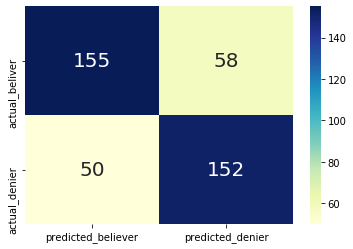

In [25]:
conf_matrix(y_test, y_pred_logit)

#### ROC Curve

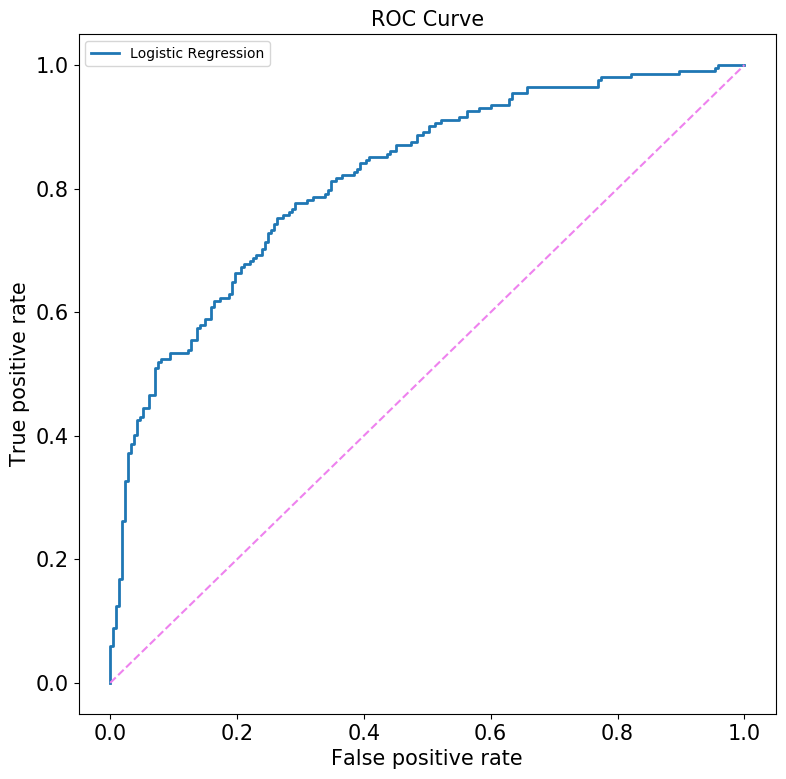

In [26]:
logit_roc = roc_curve_generator(X_test, y_test, 'Logistic Regression', logit)

#### Precision-Recall Curve

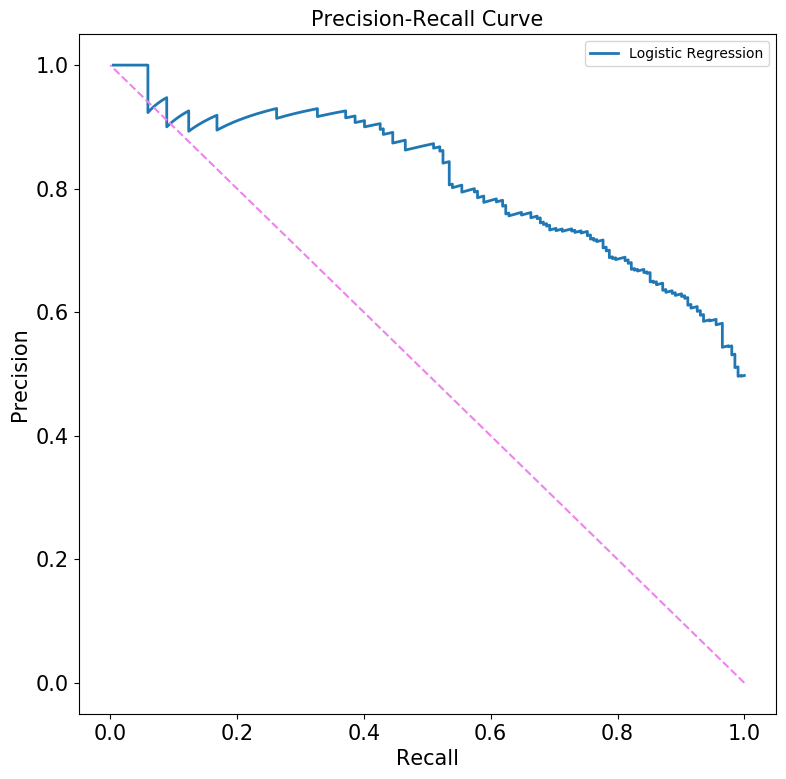

In [28]:
logit_prec_rec = prec_rec_curve_generator(X_test, y_test, 'Logistic Regression', logit)

### Random Forest

In [29]:
rf = RandomForestClassifier(n_estimators = 1000, max_depth=6, random_state=42)

In [30]:
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

#### Confusion Matrix

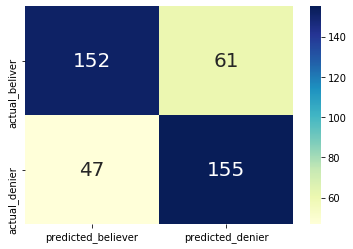

In [31]:
conf_matrix(y_test, y_pred_rf)

#### ROC Curve

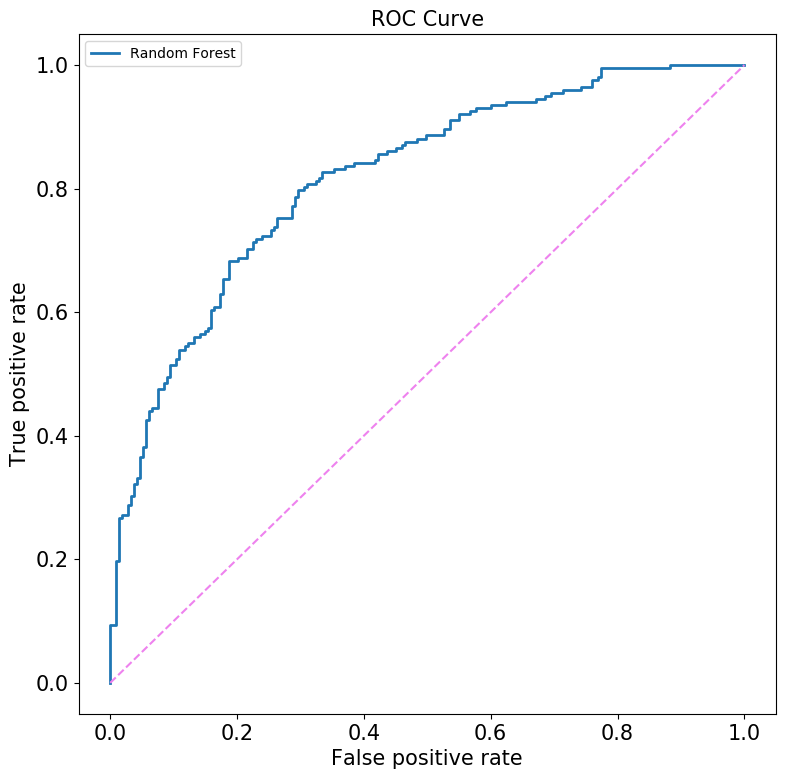

In [32]:
rf_roc = roc_curve_generator(X_test, y_test, 'Random Forest', rf)

#### Precision-Recall Curve

In [34]:
# rf_prec_rec = prec_rec_curve_generator(X_test, y_test, 'Random Forest', rf)

### XGBoost

In [35]:
xgb = XGBClassifier(n_estimators = 1000, max_depth=6, random_state=42)

In [36]:
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

#### Confusion Matrix

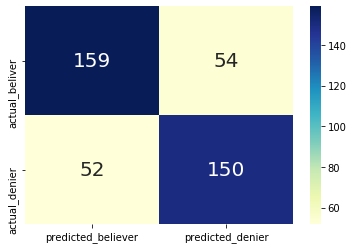

In [37]:
conf_matrix(y_test, y_pred_xgb)

#### ROC Curve

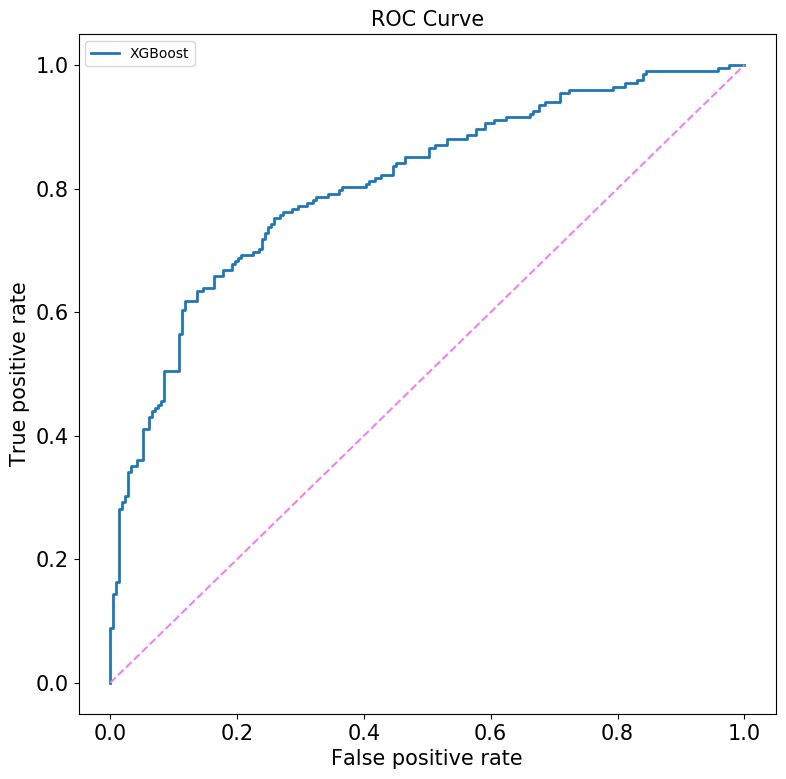

In [38]:
xgb_roc = roc_curve_generator(X_test, y_test, 'XGBoost', xgb)

#### Precision-Recall Curve

In [40]:
# xgb_prec_rec = prec_rec_curve_generator(X_test, y_test, 'XGBoost', xgb)